# Final Project

Joy Wang, Stephanie Wang, Lucinda Zhou 

CMSC320

# Data Curation and Parsing

In [2]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as OLS

For our final project, we decided to analyze the dataset from the COVID Tracking project, which is one of the open datasets from Microsoft. We utilized the CSV version of the dataset, and used pandas read_csv() to read and parse the csv file into a pandas dataframe. 

********ADD MORE ABOUT HYPOTHESIS HERE***********

While reading Microsoft's documentation for this dataset, we noticed that some columns were described as "Deprecated", so we did some preliminary data cleaning by dropping those columns from the datafram using the drop() function.

Since we are analyzing how states handled COVID based on political standards, we will not be considering territories or DC, thus we will remove those from out main dataframe.

In [3]:
# read in data and store as a dataframe
df = pd.read_csv('https://pandemicdatalake.blob.core.windows.net/public/curated/covid-19/covid_tracking/latest/covid_tracking.csv')

# remove deprecated columns based on data documentation
df = df.drop(df.columns[df.columns.str.contains('increase')], axis=1)
df = df.drop(labels=['date_checked','hospitalized','pos_neg','total'], axis=1)

# since we're looking at political leanings, we won't consider territories or DC
non_state_ids = ['AS','GU', 'MP', 'PR', 'VI','DC']
df = df.drop(df[(df['state'] == 'AS') | (df['state'] == 'GU') | (df['state'] == 'MP') | (df['state'] == 'PR') | (df['state'] == 'VI') | (df['state'] == 'DC')].index)

df

,date,state,positive,negative,pending,hospitalized_currently,hospitalized_cumulative,in_icu_currently,in_icu_cumulative,on_ventilator_currently,...,data_quality_grade,last_update_et,hash,death,total_test_results,fips,fips_code,iso_subdivision,load_time,iso_country
0,2021-03-07,AK,56886.0,NaN,NaN,33.0,1293.0,NaN,NaN,2.0,...,NaN,2021-03-05 03:59:00,dc4bccd4bb885349d7e94d6fed058e285d4be164,305.0,1731628.0,2,2,US-AK,2022-01-11 00:04:58,US
1,2021-03-07,AL,499819.0,1931711.0,NaN,494.0,45976.0,NaN,2676.0,NaN,...,NaN,2021-03-07 11:00:00,997207b430824ea40b8eb8506c19a93e07bc972e,10148.0,2323788.0,1,1,US-AL,2022-01-11 00:04:58,US
2,2021-03-07,AR,324818.0,2480716.0,NaN,335.0,14926.0,141.0,NaN,65.0,...,NaN,2021-03-07 00:00:00,50921aeefba3e30d31623aa495b47fb2ecc72fae,5319.0,2736442.0,5,5,US-AR,2022-01-11 00:04:58,US
4,2021-03-07,AZ,826454.0,3073010.0,NaN,963.0,57907.0,273.0,NaN,143.0,...,NaN,2021-03-07 00:00:00,0437a7a96f4471666f775e63e86923eb5cbd8cdf,16328.0,7908105.0,4,4,US-AZ,2022-01-11 00:04:58,US
5,2021-03-07,CA,3501394.0,NaN,NaN,4291.0,NaN,1159.0,NaN,NaN,...,NaN,2021-03-07 02:59:00,63c5c0fd2daef2fb65150e9db486de98ed3f7b72,NaN,49646014.0,6,6,US-CA,2022-01-11 00:04:58,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,2020-01-17,WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7cefac6b3681020741ca30f45399a7b22f2e45b4,NaN,NaN,53,53,US-WA,2022-01-11 00:04:58,US
22257,2020-01-16,WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,650501e005a5ee86d93c5f32dda56735ea2af967,NaN,NaN,53,53,US-WA,2022-01-11 00:04:58,US
22258,2020-01-15,WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4987e61aad88182abfe641033b597304c2153d4f,NaN,NaN,53,53,US-WA,2022-01-11 00:04:58,US
22259,2020-01-14,WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1881c8a2f0d337b22066b4f05df06eb2259e8d57,NaN,NaN,53,53,US-WA,2022-01-11 00:04:58,US


To properly compare states, we should consider per capita rates, as differently sized states will have different numbers just on the basis of population size. As such, we need to get the population data for each state. This Excel file has been downloaded from census.gov, so we can be sure of its accuracy. 

In [4]:
populations = pd.read_excel('NST-EST2021-POP.xlsx')

abbreviations = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", 
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", 
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", 
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", 
    "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT",
    "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", 
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", 
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", 
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", 
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# some rows in the table aren't actual data rows, so we'll drop them 
populations = populations.drop(index=[0, 1, 2, 59, 61, 62, 63, 64, 65])
# also drop non-state geographic areas
populations = populations.drop(index=[3, 4, 5, 6, 7, 16, 60])
# rename the columns for greater clarity 
populations.columns = ['State', '4/1/20 Population', '7/1/20 Population', '7/1/21 Population']
# our other dataset uses abbreviations, so we want to add that column to this data frame
populations['ID'] = populations.apply(lambda r: abbreviations[r['State'][1:]], axis=1)

populations

,State,4/1/20 Population,7/1/20 Population,7/1/21 Population,ID
8,.Alabama,5024279,5024803,5039877.0,AL
9,.Alaska,733391,732441,732673.0,AK
10,.Arizona,7151502,7177986,7276316.0,AZ
11,.Arkansas,3011524,3012232,3025891.0,AR
12,.California,39538223,39499738,39237836.0,CA
13,.Colorado,5773714,5784308,5812069.0,CO
14,.Connecticut,3605944,3600260,3605597.0,CT
15,.Delaware,989948,991886,1003384.0,DE
17,.Florida,21538187,21569932,21781128.0,FL
18,.Georgia,10711908,10725800,10799566.0,GA


# Joy's Work in Progress :))

# Linear Regression Modeling

## Cleaning the Dataframe

In order to make any observations regarding states' responses to COVID, we need to establish a relationship between the data in the dataframe. We have chosen the total number of people who have tested positive for COVID-19 so far as our independent variable for these models, and we will be examining three different dependent variables. One is the total number of people who have gone to the hospital for COVID-19 so far, including those who have since recovered or died. Another is the total number of people who have recovered from COVID-19 so far. Finally, we have the total number of people who have died as a result of COVID-19 so far. Based on context, these values should be dependent on positive cases, and how well the state is handling positive cases. We will construct a linear regression model which depicts the relationship between positive cases and each of these dependent variables. Depending on how well each state is handling their COVID cases, we will be able to see where they lie in comparison to other states based on the linear regression line.

Since we will only be utilizing the 'state', 'positive', 'hospitalized_cumulative', 'recovered, and 'death' columns mentioned above to establish a relationship between states, we will create a new dataframe called lrdata which only contains the necessary columns for our linear regression models. We will drop the rest of the columns, and the new dataframe should look like this.

In [5]:
# dropping unnecessary columns for linear regression models
lrdata = df.drop(df.columns[df.columns.str.contains('date|currently|iso|in|on|total|negative')], axis=1)
lrdata = lrdata.drop(labels=['data_quality_grade','hash','fips','fips_code','load_time'], axis=1)
lrdata.head()

,state,positive,hospitalized_cumulative,recovered,death
0,AK,56886.0,1293.0,NaN,305.0
1,AL,499819.0,45976.0,295690.0,10148.0
2,AR,324818.0,14926.0,315517.0,5319.0
4,AZ,826454.0,57907.0,NaN,16328.0
5,CA,3501394.0,NaN,NaN,NaN


Since our data analysis is focused on comparing separate states on these different characteristics, we will group the dataframe by the states in the 'state' column. Also, because the values in each of these columns represent cumulative numbers, it makes no sense to take the average of their values. Instead, we will take the max of these values, and assign that as the representative value for each state in each column. Thus, we will get the following dataframe.

In [6]:
# group the dataframe by state, and only take the max values in each column for each state
lrdata = lrdata.groupby('state').max()
lrdata.head()

,positive,hospitalized_cumulative,recovered,death
state,,,,
AK,56886.0,1293.0,7165.0,305.0
AL,499819.0,45976.0,295690.0,10149.0
AR,324818.0,14926.0,315517.0,5417.0
AZ,826454.0,57907.0,NaN,16328.0
CA,3501394.0,NaN,NaN,32291.0


Now that we have a dataframe that has all the values we'd like to use and is sorted by state, we need to standardize it by dividing the values for each state by its population size in order to make our observations useful. In order to do this, we will add the population sizes from the populations dataframe as a column in the lrdata dataframe. We will then divide all of the other columns by the values in this column. After that we will have this dataframe, where all values are standardized.

In [7]:
# standardize columns by the population of each state so we can compare them fairly
lrdata['population'] = lrdata.apply(lambda r: populations[populations['ID'] == r.name]['4/1/20 Population'].values[0], axis = 1)

lrdata['positive'] = lrdata['positive'] / lrdata['population']
lrdata['hospitalized_cumulative'] = lrdata['hospitalized_cumulative'] / lrdata['population']
lrdata['recovered'] = lrdata['recovered'] / lrdata['population']
lrdata['death'] = lrdata['death'] / lrdata['population']
lrdata = lrdata.reset_index()
lrdata.head()

,state,positive,hospitalized_cumulative,recovered,death,population
0,AK,0.077566,0.001763,0.009770,0.000416,733391
1,AL,0.099481,0.009151,0.058852,0.002020,5024279
2,AR,0.107858,0.004956,0.104770,0.001799,3011524
3,AZ,0.115564,0.008097,NaN,0.002283,7151502
4,CA,0.088557,NaN,NaN,0.000817,39538223


## Graphing the Data and Lin Reg Models

Now that we have cleaned up the dataframe, we can now create linear regression models which will establish a relationship between the data and different states. We will be creating three graphs with linear regression models for 3 different relationships. The method used for each model is the same. First, we will drop rows with NaN values in the columns that we are graphing, since those values will interfere with modeling. First, we will graph all of the points as a scatter plot, labeling each point with the state it represents. Then we will use numpy polyfit() to create a linear regression model for this relationship, and graph it as well. We will then use this depiction of the data to make observations for the states regarding each relationship.

### Positive Cases vs. Cumulative Hospitalized

<AxesSubplot:title={'center':'Positive Cases vs. Cumulative Hospitalized'}, xlabel='Positive Cases', ylabel='Cumulative Hospitalized'>

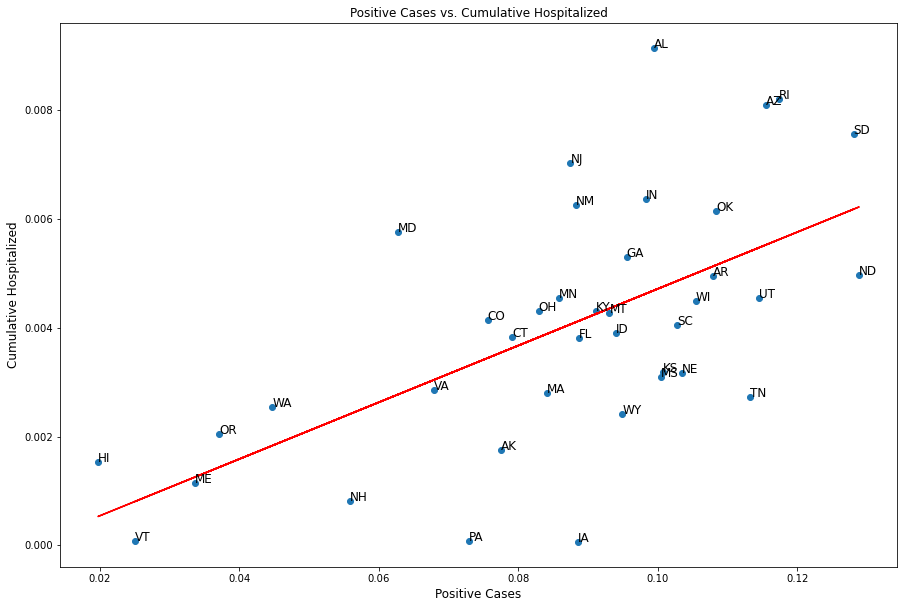

In [8]:
# lin reg for positive to hospitalization relationship
# remove NaN values
lr_hospital = lrdata.dropna(subset=['positive', 'hospitalized_cumulative'])
lr_hospital.reset_index(drop=True, inplace=True)

x = pd.to_numeric(lr_hospital['positive'])
y = pd.to_numeric(lr_hospital['hospitalized_cumulative'])
# create plot for positive to hospitalization relationship
fig, ax = plt.subplots()
ax.scatter(x,y)
# annotate the points with state names
for i, txt in enumerate(lr_hospital.state):
    ax.annotate(txt, (x[i], y[i]), fontsize = 12)
# create and plot lin reg line
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color="red")
# label and enlarge the graph
ax.set_title("Positive Cases vs. Cumulative Hospitalized", fontsize = 12)
ax.set_xlabel("Positive Cases", fontsize = 12)
ax.set_ylabel("Cumulative Hospitalized", fontsize = 12)
fig.set_figwidth(15)
fig.set_figheight(10)
ax

Above, we see a depiction of the relationship between positive cases and the number of people who are hospitalized. Intuitively, a higher amount of positive cases suggests more people who are hospitalized, and the linear regression line supports this. The states with their point above this line have more hospitalized than the lin reg model expects at that number of positive cases, while states with their point below this line have less hospitalized than the lin reg model expects at that number of positive cases. It is ideal for a state to be below the line, since that suggests they are doing well at mitigating hospitalization among positive cases in comparison to other states. Some states which are notable for this in the plot include VT, NH, PA, and IA, and on the other hand, AL, whose point lies far above the line, may not be handling hospitalization rates as well.

### Positive Cases vs. Cumulative Recovered

<AxesSubplot:title={'center':'Positive Cases vs. Cumulative Recovered'}, xlabel='Positive Cases', ylabel='Cumulative Recovered'>

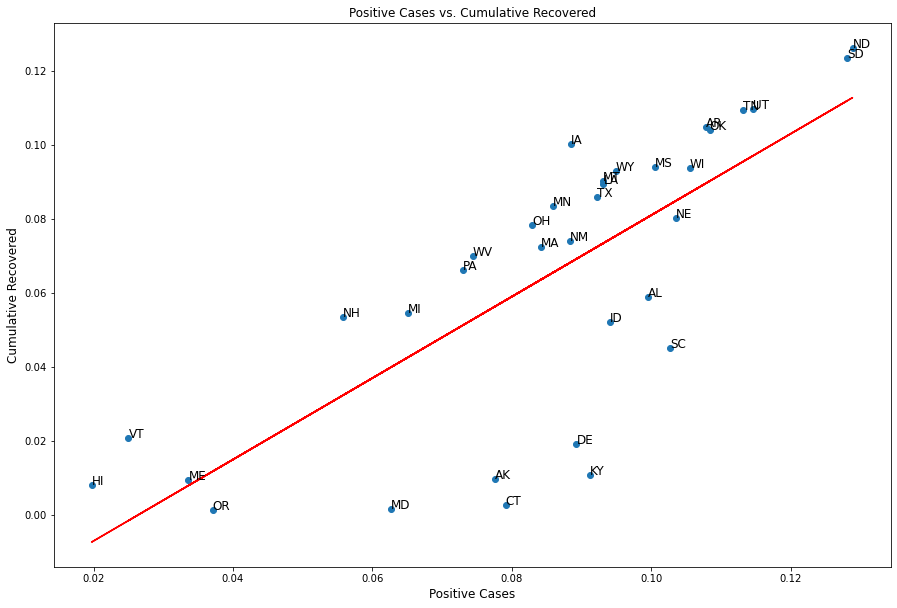

In [9]:
# lin reg for positive to recovered relationship
# remove NaN values
lr_recovered = lrdata.dropna(subset=['positive', 'recovered'])
lr_recovered.reset_index(drop=True, inplace=True)

x = pd.to_numeric(lr_recovered['positive'])
y = pd.to_numeric(lr_recovered['recovered'])
# create plot for positive to recovered relationship
fig, ax = plt.subplots()
ax.scatter(x,y)
# annotate the points with state names
for i, txt in enumerate(lr_recovered.state):
    ax.annotate(txt, (x[i], y[i]), fontsize = 12)
# create and plot lin reg line
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color="red")
# label and enlarge the graph
ax.set_title("Positive Cases vs. Cumulative Recovered", fontsize = 12)
ax.set_xlabel("Positive Cases", fontsize = 12)
ax.set_ylabel("Cumulative Recovered", fontsize = 12)
fig.set_figwidth(15)
fig.set_figheight(10)
ax

Plotted above, we see a depiction of the relationship between positive cases and the number of people who have recovered. Intuitively, a higher amount of positive cases suggests that more people would have recovered, and the linear regression line supports this. The states with their point above this line have more people recovered than the lin reg model expects at that number of positive cases, while states with their point below this line have less people recovered than the lin reg model expects at that number of positive cases. It is ideal for a state to be above the line, since that suggests they are doing well at encouraging recovery among positive cases in comparison to other states. Some states which are notable for this in the plot include VT, NH, and IA, and on the other hand, CT and KY, whose points lies far below the line, may not be supporting and speeding up recovery as well.

### Positive Cases vs. Cumulative Death

<AxesSubplot:title={'center':'Positive Cases vs. Cumulative Death'}, xlabel='Positive Cases', ylabel='Cumulative Death'>

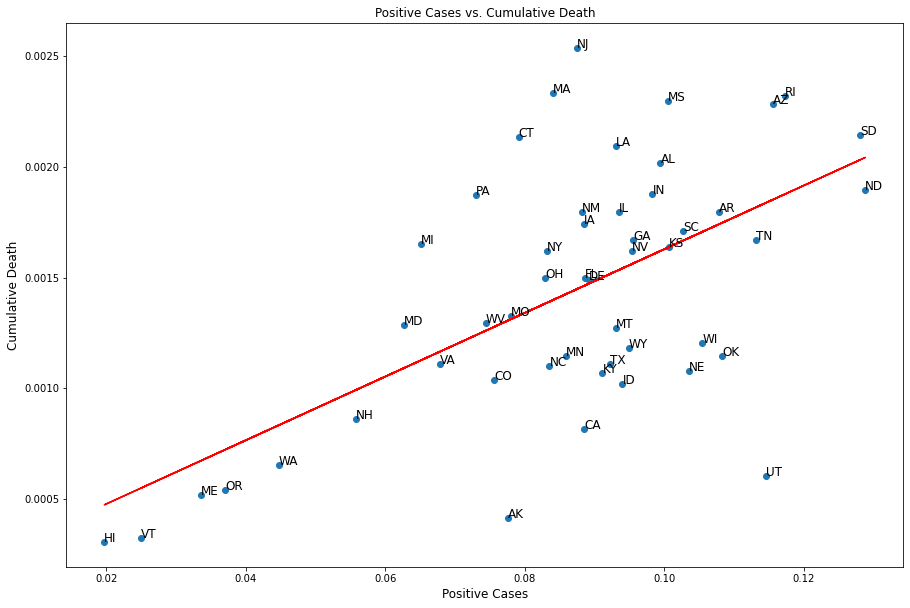

In [10]:
# lin reg for positive to death relationship
# remove NaN values
lr_death = lrdata.dropna(subset=['positive', 'death'])

x = pd.to_numeric(lr_death['positive'])
y = pd.to_numeric(lr_death['death'])
# create plot for positive to death relationship
fig, ax = plt.subplots()
ax.scatter(x,y)
# annotate the points with state names
for i, txt in enumerate(lr_death.state):
    ax.annotate(txt, (x[i], y[i]), fontsize = 12)
# create and plot lin reg line
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color="red")
# label and enlarge the graph
ax.set_title("Positive Cases vs. Cumulative Death", fontsize = 12)
ax.set_xlabel("Positive Cases", fontsize = 12)
ax.set_ylabel("Cumulative Death", fontsize = 12)
fig.set_figwidth(15)
fig.set_figheight(10)
ax

Above, we see a depiction of the relationship between positive cases and the number of people who have died. Intuitively, a higher amount of positive cases suggests there are more people who have died, and the linear regression line supports this. The states with their point above this line have more deaths than the lin reg model expects at that number of positive cases, while states with their point below this line have less deaths than the lin reg model expects at that number of positive cases. It is ideal for a state to be below the line, since that suggests they are doing well at mitigating the number of deaths among positive cases in comparison to other states. Some states which are notable for this in the plot include AK, CA, and UT, and on the other hand, NJ, MA, and CT, whose points lies far above the line, may not be as successful at lowering death rates among positive COVID cases.

## General Observations

see if there's a state that does consistently well
CROSS ANALYSIS WITH LUCY'S STUFF LATER

# Stephanie's WIP

Since we are looking to see if there's a difference in how states compare to each other in terms of COVID data based on political leaning, we can also try doing k-means clustering on our data to see if states are clustered into distinct groups based on their COVID statistics. Particularly, we want to see if we get two distinct groups that match the political leanings of red vs blue. 

We can start out by simply dropping irrelevant columns. Since the majority of our columns, and in particular important columns such as `positive` and `negative`, are cumulative, we'll look at cumulative values for each state. 

In [10]:
kmdata = df.copy()
# drop non numerical columns 
kmdata = kmdata.drop(
    labels=['date', 'data_quality_grade', 'last_update_et', 'hash', 'load_time', 'iso_subdivision', 'iso_country', 'fips', 'fips_code'], 
    axis=1
)
# drop non cumulative columns 
kmdata = kmdata.drop(
    labels=['hospitalized_currently', 'in_icu_currently', 'on_ventilator_currently'], 
    axis=1
)
# get max values for the cumulative columns
kmdata = kmdata.groupby('state').max()
kmdata.head()

,positive,negative,pending,hospitalized_cumulative,in_icu_cumulative,on_ventilator_cumulative,recovered,death,total_test_results
state,,,,,,,,,
AK,56886.0,NaN,14.0,1293.0,NaN,NaN,7165.0,305.0,1731628.0
AL,499819.0,1931711.0,46.0,45976.0,2676.0,1515.0,295690.0,10149.0,2323788.0
AR,324818.0,2480716.0,203.0,14926.0,43.0,1533.0,315517.0,5417.0,2736442.0
AZ,826454.0,3073010.0,130.0,57907.0,NaN,NaN,NaN,16328.0,7908105.0
CA,3501394.0,266839.0,15000.0,NaN,NaN,NaN,NaN,32291.0,49646014.0


We can see that many of these columns have NaN values. K-means clustering cannot be done with NaN values, and there is no accurate way to determine what the values may be. As such, we'll simply remove all columns with NaN values. The extra benefit of this is that k-means clustering becomes inaccurate with too many dimensions, so we would have needed to remove columns or do dimension reduction regardless. 

In [11]:
kmdata = kmdata.dropna(axis=1)
kmdata.head()

,positive,death,total_test_results
state,,,
AK,56886.0,305.0,1731628.0
AL,499819.0,10149.0,2323788.0
AR,324818.0,5417.0,2736442.0
AZ,826454.0,16328.0,7908105.0
CA,3501394.0,32291.0,49646014.0


As previously stated, we want to perform our data analysis on per capita rates rather than raw numbers, so that results are not inaccurately biased by differing state populations. Since most of our data is in 2020, we'll use the April 1, 2020 population estimates. 

In [12]:
# adding population to the data table to make calculations easier 
kmdata['population'] = kmdata.apply(
    lambda r: populations[populations['ID'] == r.name]['4/1/20 Population'].values[0],
    axis = 1
)

percapita = kmdata.copy()
percapita['positive'] = kmdata['positive'] / kmdata['population']
percapita['death'] = kmdata['death'] / kmdata['population']
percapita['total_test_results'] = kmdata['total_test_results'] / kmdata['population']
percapita = percapita.drop(labels=['population'], axis=1)
percapita.head()

,positive,death,total_test_results
state,,,
AK,0.077566,0.000416,2.361125
AL,0.099481,0.002020,0.462512
AR,0.107858,0.001799,0.908657
AZ,0.115564,0.002283,1.105796
CA,0.088557,0.000817,1.255646


We can see from the first few data points that the different variables seem to be on different scales. We'll standardize our data points to prevent inaccuracies due to unit differences. 

In [13]:
kmdata_scaled = percapita.copy()
kmdata_scaled[percapita.columns] = StandardScaler().fit_transform(percapita)
kmdata_scaled.head()

,positive,death,total_test_results
state,,,
AK,-0.361915,-1.793176,2.459706
AL,0.562421,1.045757,-1.333330
AR,0.915773,0.654221,-0.442024
AZ,1.240770,1.511503,-0.048180
CA,0.101685,-1.083800,0.251188


To get a sense of what our data looks like, we can make a 3D scatterplot of the points.

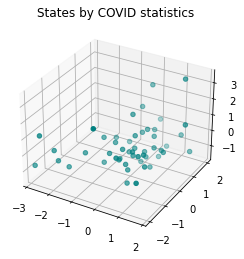

In [14]:
ax = plt.axes(projection='3d')
ax.scatter3D(kmdata_scaled['positive'], kmdata_scaled['death'], kmdata_scaled['total_test_results'], color='teal')
ax.set_title('States by COVID statistics')
plt.show()

From just looking at the graph, we don't have two distinct groups. Still, we can do clustering on this and replot to see how the different groups fall. Since we're looking to find a difference between red and blue states, we'll use two clusters. 

In [15]:
X = kmdata_scaled.values

km = KMeans(n_clusters=2, init='k-means++')
y = km.fit_predict(X)
kmdata_scaled['group'] = y

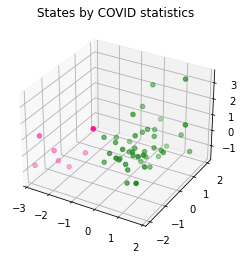

In [16]:
group0 = kmdata_scaled[kmdata_scaled['group'] == 0]
group1 = kmdata_scaled[kmdata_scaled['group'] == 1]

ax = plt.axes(projection='3d')
ax.scatter3D(group0['positive'], group0['death'], group0['total_test_results'], color='forestgreen')
ax.scatter3D(group1['positive'], group1['death'], group1['total_test_results'], color='deeppink')
ax.set_title('States by COVID statistics')
plt.show()

In [17]:
group0.index

Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL',
       'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC',
       'ND', 'NE', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'PA', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [18]:
group1.index

Index(['AK', 'HI', 'ME', 'NH', 'OR', 'VT', 'WA'], dtype='object', name='state')

Based on the states that fall into the two groups, it does not seem that the grouping matches red/blue leanings. 

Most news regarding COVID rates in red versus blue states have discussed how political leanings impact positive tests and death rates, but not total test numbers. We can try removing the `total_test_results` column and only focus on positive rates and death rates to see if we get different results. 

In [19]:
kmdata_scaled = kmdata_scaled.drop(labels=['total_test_results', 'group'], axis=1)
kmdata_scaled.head()

,positive,death
state,,
AK,-0.361915,-1.793176
AL,0.562421,1.045757
AR,0.915773,0.654221
AZ,1.240770,1.511503
CA,0.101685,-1.083800


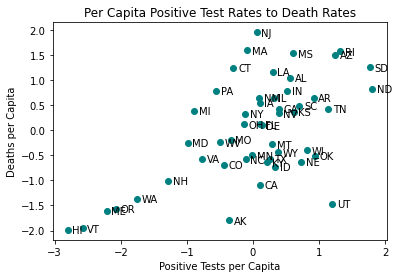

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(kmdata_scaled['positive'], kmdata_scaled['death'], color='teal')

ax.set_title('Per Capita Positive Test Rates to Death Rates')
ax.set_xlabel('Positive Tests per Capita')
ax.set_ylabel('Deaths per Capita')

# label each point on the graph 
for row in kmdata_scaled.iterrows():
    ax.annotate(row[0], (row[1]['positive'] + 0.07, row[1]['death'] - 0.07))

plt.show()

Since we're trying to separate the points into two groups by political leaning, we'll have two clusters for our K-means clustering. We can use k-means++ to make sure our initial clusters are selected well for accurate results. 

In [21]:
X = kmdata_scaled.values

km = KMeans(n_clusters=2, init='k-means++')
y = km.fit_predict(X)
kmdata_scaled['group'] = y

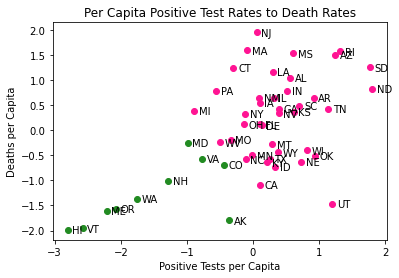

In [22]:
group0 = kmdata_scaled[kmdata_scaled['group'] == 0]
group1 = kmdata_scaled[kmdata_scaled['group'] == 1]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(group0['positive'], group0['death'], color='forestgreen')
ax.scatter(group1['positive'], group1['death'], color='deeppink')

ax.set_title('Per Capita Positive Test Rates to Death Rates')
ax.set_xlabel('Positive Tests per Capita')
ax.set_ylabel('Deaths per Capita')

# label each point on the graph 
for row in kmdata_scaled.iterrows():
    ax.annotate(row[0], (row[1]['positive'] + 0.07, row[1]['death'] - 0.07))

plt.show()

In [23]:
group0.index

Index(['AK', 'CO', 'HI', 'MD', 'ME', 'NH', 'OR', 'VA', 'VT', 'WA'], dtype='object', name='state')

In [24]:
group1.index

Index(['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN',
       'KS', 'KY', 'LA', 'MA', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [25]:
# maybe do some more plotting with the actual alignment percentages?

states still don't match up with red/blue alignment (more thoughtful analysis)

# Lucinda's WIP
# Positive Infections and Party Affiliations
We will also be looking to see if there is any correlation between the political leaning of each state and its number of positive infections.

The groups don't completely match up to our previous clustering, but they still also don't match up with blue/red alignment. 

(more thoughtful analysis)

## Grouping by state
Group the data by state and displaying it to see if there are any initial issues with it.

In [26]:
# group by state and get max of each col (since numbers in rows are cumulative)
covid_data = lrdata.groupby("state").max()

print(covid_data.count())
covid_data

positive                   50
hospitalized_cumulative    39
recovered                  34
death                      50
population                 50
dtype: int64


,positive,hospitalized_cumulative,recovered,death,population
state,,,,,
AK,0.077566,0.001763,0.009770,0.000416,733391
AL,0.099481,0.009151,0.058852,0.002020,5024279
AR,0.107858,0.004956,0.104770,0.001799,3011524
AZ,0.115564,0.008097,NaN,0.002283,7151502
CA,0.088557,NaN,NaN,0.000817,39538223
CO,0.075619,0.004140,NaN,0.001037,5773714
CT,0.079128,0.003825,0.002718,0.002136,3605944
DE,0.089251,NaN,0.019042,0.001488,989948
FL,0.088643,0.003818,NaN,0.001498,21538187


There are some missing data values for some states in the hospitalized_cumulative and recovered columns. However, we are only plotting the positive values in this section and that column has data for all 50 states, so we are good to go.

## 2020 Election Dataset
We will now need data on the political leanings of each state. Since the pandemic occured during the 2020 election, data from this election will be the most interesting to analyze. We found a Kaggle dataset that contains information about the number of votes broken down to each county:
https://www.kaggle.com/datasets/unanimad/us-election-2020?resource=download&select=president_county_candidate.csv
<br>

We can group this data by state to use in our analysis. The data only shows the raw number of votes by default, but percentages are what we want to analyze. As such, for each state, we will be getting the number of votes for the democratic and republican parties and dividing it by the total number of votes for that state and using this as an indicator of the political leanings of the state.

In [27]:
# read table
elections = pd.read_csv("president_county_candidate.csv")

# group table by state and party, remove DC
filtered = elections[elections["party"] == "DEM"]
grouped = filtered.groupby(["state", "party"]).sum()
grouped = grouped.drop(index=["District of Columbia"])

# get totals
total = elections.groupby("state").sum()
total = total.drop(index=["District of Columbia"])

# loop through and get democratic percentage
for index, row in grouped.iterrows():
    total.at[index[0],"dem_pct"] = row["total_votes"]/total["total_votes"][index[0]]

    
# change to state abbreviations instead of full names
total["stateID"] = ["AL", "AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
total = total.set_index("stateID")
total



,total_votes,won,dem_pct
stateID,,,
AL,2323304,67,0.365707
AK,391346,40,0.391993
AZ,3387326,15,0.493647
AR,1219069,75,0.347751
CA,17495906,58,0.634992
CO,3256953,64,0.554000
CT,1824280,169,0.592387
DE,504010,3,0.587822
FL,11067456,67,0.478615


There are some missing data values for some states in the hospitalized_cumulative and recovered columns. However, we are only plotting the positive values in this section and that column has data for all 50 states, so we are good to go.

## 2020 Election Dataset
We will now need data on the political leanings of each state. Since the pandemic occured during the 2020 election, data from this election will be the most interesting to analyze. We found a Kaggle dataset that contains information about the number of votes broken down to each county:
https://www.kaggle.com/datasets/unanimad/us-election-2020?resource=download&select=president_county_candidate.csv
<br>

We can group this data by state to use in our analysis. The data only shows the raw number of votes by default, but percentages are what we want to analyze. As such, for each state, we will be getting the number of votes for the democratic and republican parties and dividing it by the total number of votes for that state and using this as an indicator of the political leanings of the state.

In [28]:
# read table
elections = pd.read_csv("president_county_candidate.csv")
      
# group table by state and democractic party, remove DC
filtered_dem = elections[elections["party"] == "DEM"]
grouped_dem = filtered_dem.groupby(["state", "party"]).sum()
grouped_dem = grouped_dem.drop(index=["District of Columbia"])

# group table by state and republican party, remove DC
filtered_rep = elections[elections["party"] == "REP"]
grouped_rep = filtered_rep.groupby(["state", "party"]).sum()
grouped_rep = grouped_rep.drop(index=["District of Columbia"])

# get totals
total = elections.groupby("state").sum()
total = total.drop(index=["District of Columbia"])

# loop through and get democratic and republican percentages
for index, row in grouped_dem.iterrows():
    total.at[index[0],"dem_pct"] = row["total_votes"]/total["total_votes"][index[0]]

for index, row in grouped_rep.iterrows():
    total.at[index[0],"rep_pct"] = row["total_votes"]/total["total_votes"][index[0]]
    
# change to state abbreviations instead of full names, set as index
total["stateID"] = ["AL", "AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
total = total.set_index("stateID")

sum_column = total["dem_pct"] + total["rep_pct"]
total["total_pct"] = sum_column
total

,total_votes,won,dem_pct,rep_pct,total_pct
stateID,,,,,
AL,2323304,67,0.365707,0.620310,0.986016
AK,391346,40,0.391993,0.485228,0.877221
AZ,3387326,15,0.493647,0.490560,0.984207
AR,1219069,75,0.347751,0.623957,0.971708
CA,17495906,58,0.634992,0.343278,0.978270
CO,3256953,64,0.554000,0.418983,0.972983
CT,1824280,169,0.592387,0.392095,0.984482
DE,504010,3,0.587822,0.398014,0.985836
FL,11067456,67,0.478615,0.512198,0.990813


## Merging the tables and categorizing
Now that we have the data for the percentage of votes in each state that were for the democratic party in a column, we can merge this column into the covid_data from earlier that has the data on infections.

In [29]:
total_pol = pd.concat([covid_data, total["dem_pct"], total["rep_pct"], total["total_pct"]],axis=1)
total_pol

,positive,hospitalized_cumulative,recovered,death,population,dem_pct,rep_pct,total_pct
AK,0.077566,0.001763,0.009770,0.000416,733391,0.391993,0.485228,0.877221
AL,0.099481,0.009151,0.058852,0.002020,5024279,0.365707,0.620310,0.986016
AR,0.107858,0.004956,0.104770,0.001799,3011524,0.347751,0.623957,0.971708
AZ,0.115564,0.008097,NaN,0.002283,7151502,0.493647,0.490560,0.984207
CA,0.088557,NaN,NaN,0.000817,39538223,0.634992,0.343278,0.978270
CO,0.075619,0.004140,NaN,0.001037,5773714,0.554000,0.418983,0.972983
CT,0.079128,0.003825,0.002718,0.002136,3605944,0.592387,0.392095,0.984482
DE,0.089251,NaN,0.019042,0.001488,989948,0.587822,0.398014,0.985836
FL,0.088643,0.003818,NaN,0.001498,21538187,0.478615,0.512198,0.990813
GA,0.095547,0.005302,NaN,0.001672,10711908,0.494953,0.492596,0.987549


We can now categorize each state based on the percentage of votes that were for the democratic and republican party in each state. If a state had more votes cast for the republican party, it is considered red. If it had more cast for the democractic party, it is considered blue.

In [31]:
# loop through and get democratic and republican percentages
for index, row in total_pol.iterrows():
    if row["dem_pct"] > row["rep_pct"]:
        total_pol.at[index,"party"] = "blue"
    else:
        total_pol.at[index,"party"] = "red"
total_pol

,positive,hospitalized_cumulative,recovered,death,population,dem_pct,rep_pct,total_pct,party
AK,0.077566,0.001763,0.009770,0.000416,733391,0.391993,0.485228,0.877221,red
AL,0.099481,0.009151,0.058852,0.002020,5024279,0.365707,0.620310,0.986016,red
AR,0.107858,0.004956,0.104770,0.001799,3011524,0.347751,0.623957,0.971708,red
AZ,0.115564,0.008097,NaN,0.002283,7151502,0.493647,0.490560,0.984207,blue
CA,0.088557,NaN,NaN,0.000817,39538223,0.634992,0.343278,0.978270,blue
CO,0.075619,0.004140,NaN,0.001037,5773714,0.554000,0.418983,0.972983,blue
CT,0.079128,0.003825,0.002718,0.002136,3605944,0.592387,0.392095,0.984482,blue
DE,0.089251,NaN,0.019042,0.001488,989948,0.587822,0.398014,0.985836,blue
FL,0.088643,0.003818,NaN,0.001498,21538187,0.478615,0.512198,0.990813,red
GA,0.095547,0.005302,NaN,0.001672,10711908,0.494953,0.492596,0.987549,blue


## TODO: Merge with COVID dataframe, plot stuff, see if any patterns